# KODLUYORUZ'S K136 İSTANBUL DATA SCIENCE BOOTCAMP

## GROUP 6 - DETERMINATION OF SUITABLE İSBIKE POINTS FOR KADIKÖY REGION

### Adding Libraries and Defining Classes

#### Adding Libraries

In [1]:
# Connecting Colab to Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install geopandas        # for Colab
#!pip install shapely          # for Colab
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import folium
from shapely.geometry import Point

#### Kadıköy Geojson Verisinin Alınması ve Temizlenmesi

In [3]:
kadikoy = gpd.read_file(r"..\Data\KadikoyMap.geojson")        # for local
#kadikoy = gpd.read_file("/content/drive/MyDrive/Bootcamp-Grup6/KadikoyMap.geojson")                 # for Colab
# Deletion of unnecessary information. The first 21 are sufficient as they contain multiple lines of geographic data. 
kadikoy = kadikoy.iloc[:21]

#### DrawMap Function (Drawing geojson points on Base Map)

In [4]:
def DrawMap(act, title, district=kadikoy):
    """ 
    It takes act, title and district as parameters.
    act = geojson, title = title of the drawn map, district (default = kadikoy) = the region to be drawn
    It plots the relevant geojson points on the relevant Base Map as output.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    district.plot(ax=ax)
    act.plot(ax=ax, color="red")
    ax.set_title(title, fontdict={'fontsize': 30})
    ax.set_ylabel('Latitude', fontdict={'fontsize': 20})
    ax.set_xlabel('Longitude', fontdict={'fontsize': 20})

#### CentAndLatLot Function (Editing coordinates before modelling)

In [5]:
# Extracting coordinates before inserting them into the K-means model
def CentAndLatLot(dataframe):
    """
    Takes df as a parameter.
    Sets the coordinates before inserting the dataframe into the k-means model.
    Returns the dataframe.
    """
    for i in range(len(dataframe)):
        dataframe.geometry[i] = dataframe.geometry[i].centroid

    dataframe["lat"] = "none"
    dataframe["lon"] = "none"

    for i in range(len(dataframe)):
        dataframe.lat[i] = dataframe.geometry[i].x
        dataframe.lon[i] = dataframe.geometry[i].y

    dataframe = dataframe.astype({"lat": float}, errors='raise')
    dataframe = dataframe.astype({"lon": float}, errors='raise')

    return dataframe

#### ClusterNum Function (determining the number of clusters)

In [6]:
# Determining the number of clusters required for K-means
def ClusterNum(dataframe, weighted='weight'):
    """
    Takes the dataframe, weighted, as a parameter.
    It determines the number of clusters required for the K-means model.
    It draws the Elbow method as output.
    """
    x = dataframe[["lon", "lat"]]
    wcss = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(x, sample_weight=dataframe[weighted])
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 10), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


#### ClusterModel Function (the function that creates the K-means model and determines the centers)

In [7]:
# Function that creates the K-means model and determines the centers of the clusters
def ClusterModel(noc, dataframe, weighted='weight'):
    """
    Takes noc, dataframe, weighted as parameters.
    noc = number of clusters (int), dataframe = dataframe, weighted (default = "weight") = weight
    Returns dtf_X (the lat, lon and cluster of points to which they belong) and center (lat and lon of cluster points) as output.
    """
    x = dataframe[["lat", "lon"]]
    model = KMeans(n_clusters=noc, init='k-means++', max_iter=300, n_init=10, random_state=0)

    dtf_X = x.copy()
    dtf_X["cluster"] = model.fit_predict(x, sample_weight=dataframe[weighted])

    center = model.cluster_centers_
    return [dtf_X, center]

#### ClusterMap Function (Plotting clusters and cluster centers in Base Map.)

In [8]:
# Displaying clusters and cluster centers on the map after model setup
def ClusterMap(model, center, district=kadikoy):
    """
    Plotting of clusters and cluster centers on Base Map.
    It takes model, center, district (default = kadikoy) as a parameter.
    It draws clusters and cluster centers on Base Map as output.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    district.plot(ax=ax, color="powderblue")
    model.plot.scatter(ax=ax, x='lat', y='lon', c="cluster", s=50, cmap='Accent_r')
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, alpha=0.5)


#### DrawRealMap Function (Displaying clusters on real map)

In [9]:
# Displaying clusters on Open Street Map
def DrawRealMap(centers, color):
    """
    Display of clusters on real map.
    Takes centers, color as a parameter.
    It shows the clusters on the real map as output.
    """
    map = folium.Map(location=[40.98664398, 29.08949883], zoom_start=12)
    for c in centers:
        folium.Marker(
            location = [c[1], c[0]],
            icon = folium.Icon(color=color),
            popup = f'<b>Cluster Point</b><br>lat:{c[1]}, lon:{c[0]}',
            tooltip = "Click for more"
        ).add_to(map)
    #display(map)
    return map

### Creating Maps

#### Creation of Kadıköy Neighborhoods Map

Text(0.5, 163.20501922395357, 'Longitude')

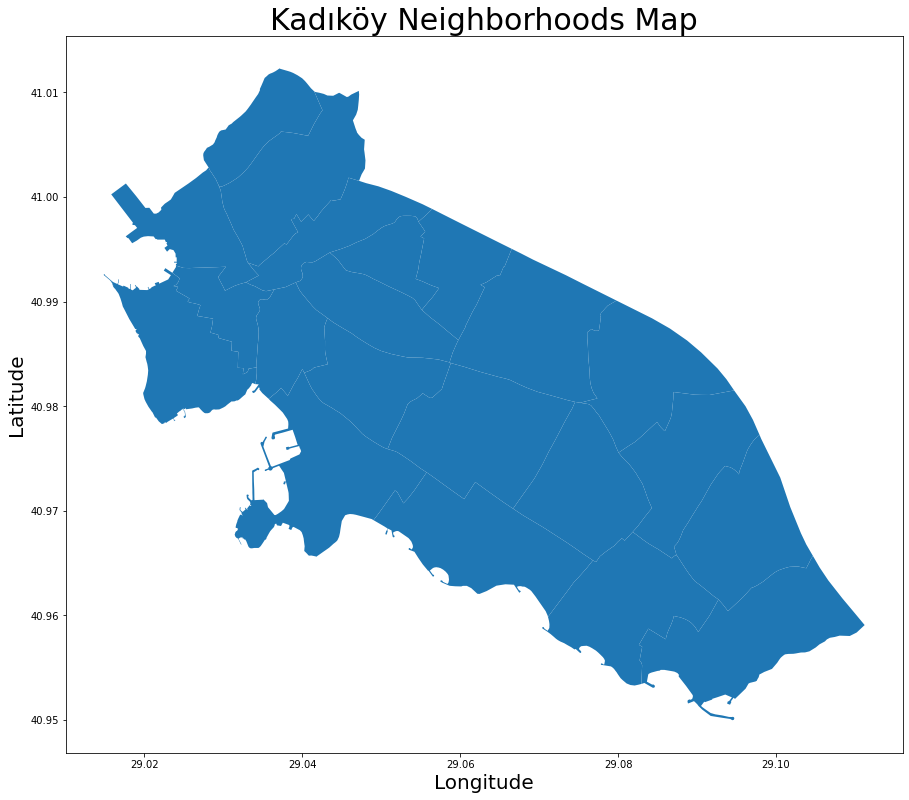

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
kadikoy.plot(ax=ax)
ax.set_title('Kadıköy Neighborhoods Map', fontdict={'fontsize': 30})
ax.set_ylabel('Latitude', fontdict={'fontsize': 20})
ax.set_xlabel('Longitude', fontdict={'fontsize': 20})

#### Kadıköy Density Map

In [11]:
# Taking the population of Kadıköy neighborhood
df = pd.read_excel(open(r"..\Data\KadikoyNeighborhoodPopulations.xlsx", 'rb'))       # for local
#df = pd.read_excel("/content/drive/MyDrive/Bootcamp-Grup6/KadikoyNeighborhoodPopulations.xlsx")                            # for Colab

# merging kadikoy with df
df_kadikoy = pd.merge(kadikoy, df, how='inner', on='name')

# To create a weighted model by population
df_kadikoy_den = CentAndLatLot(df_kadikoy)

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


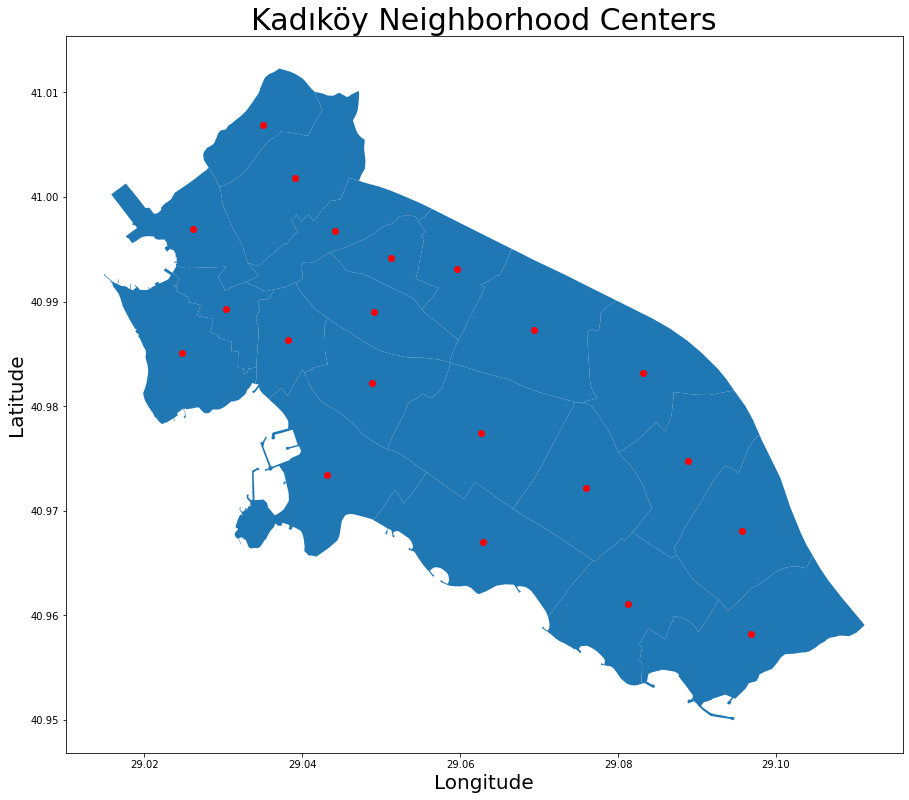

In [12]:
DrawMap(df_kadikoy_den, "Kadıköy Neighborhood Centers")

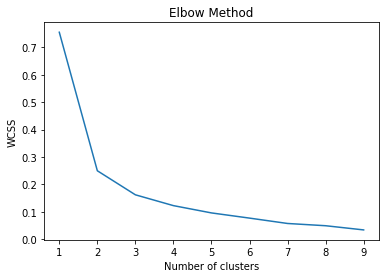

In [13]:
# Elbow for population density
ClusterNum(df_kadikoy_den, weighted="density")

In [14]:
# Kadıköy density model
density_model, density_center = ClusterModel(3, df_kadikoy_den, weighted="density")

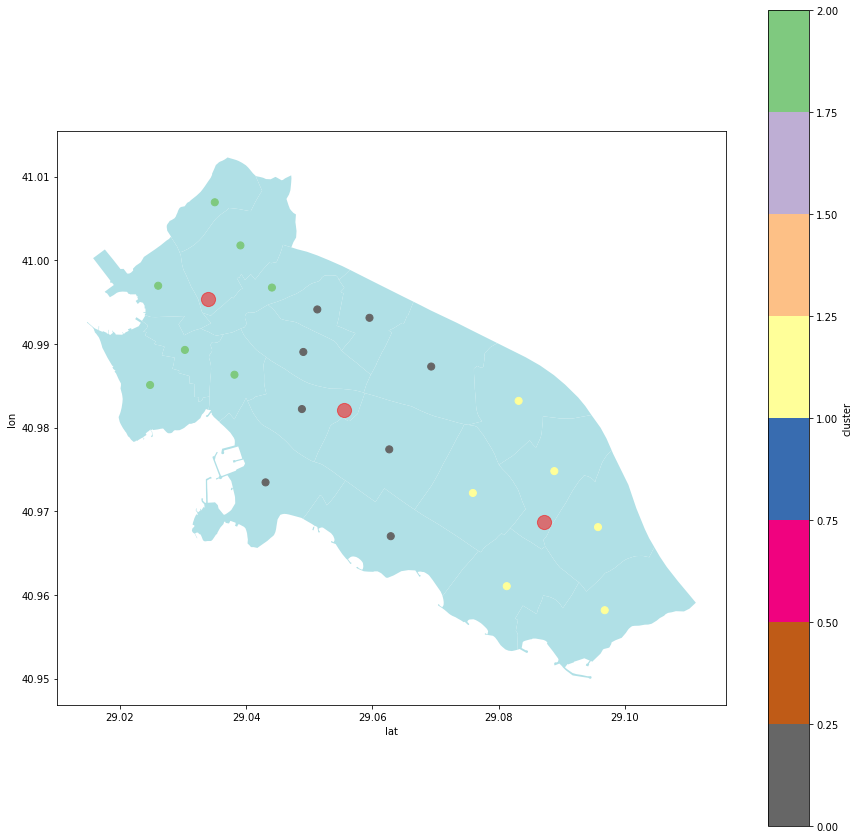

In [15]:
ClusterMap(density_model, density_center)

In [16]:
# Kadıköy population model
DrawRealMap(density_center, "green")

#### Kadıköy Public Transport Stations Map

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\3891511638.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  public_trans = bus.append(pt, ignore_index=True)


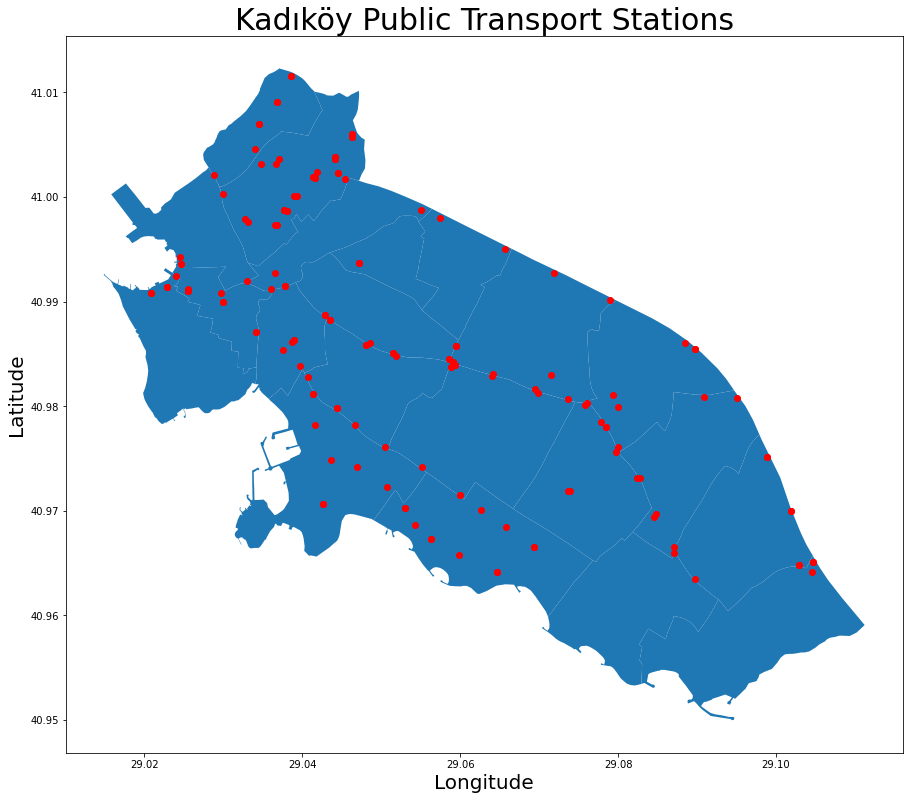

In [17]:
bus = gpd.read_file('..\Data\BusStations.geojson')           # for local
pt = gpd.read_file('..\Data\PublicTransport.geojson')        # for local
#bus = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/BusStations.geojson')                   # for Colab
#pt = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/PublicTransport.geojson')                # for Colab


for i in range(len(pt)):
    pt.geometry[i] = bus.geometry[i].centroid

public_trans = bus.append(pt, ignore_index=True)
DrawMap(public_trans, "Kadıköy Public Transport Stations")

In [18]:
public_trans = CentAndLatLot(public_trans)
public_trans['weight'] = 1

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


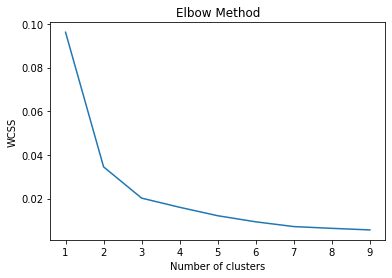

In [19]:
# Determining the number of clusters for public_trans
ClusterNum(public_trans)

In [20]:
# Model and cluster centers created for public_trans
public_model, public_center = ClusterModel(3, public_trans)

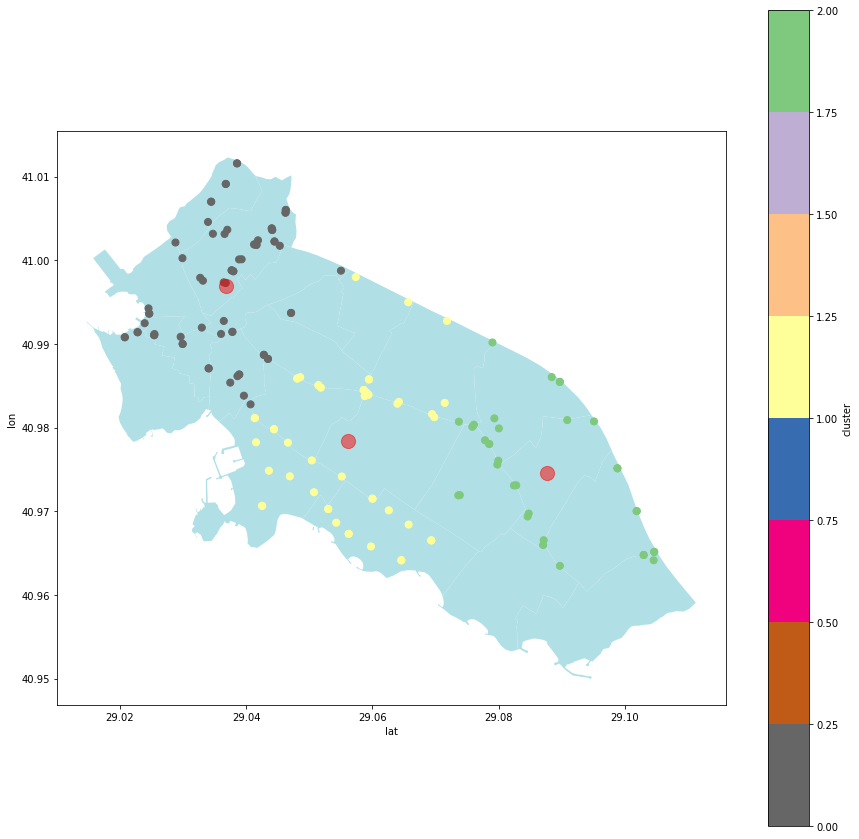

In [21]:
ClusterMap(public_model, public_center)

In [22]:
# Plotting public_center on real map
DrawRealMap(public_center, "red")

#### Kadıköy Park Map

In [23]:
park = gpd.read_file('..\Data\Park.geojson')      # for local
#park = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/Park.geojson')              # for Colab
park["AreaSize"] = park.area

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\812580017.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park["AreaSize"] = park.area


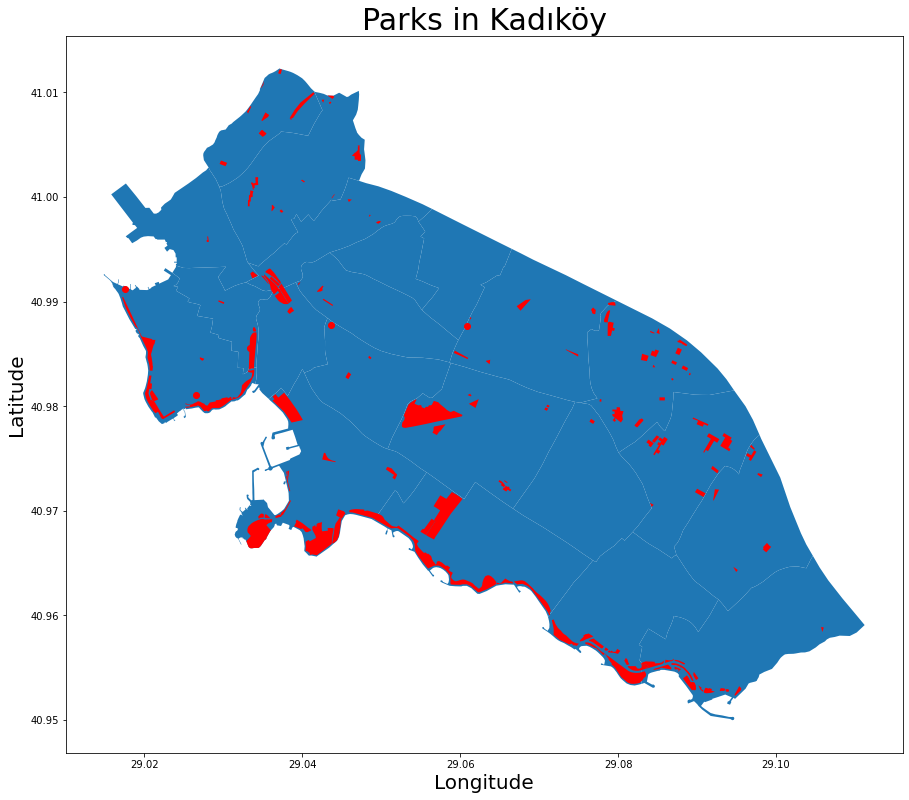

In [24]:
# Drawing of parks in Kadıköy
DrawMap(park, "Parks in Kadıköy")

In [25]:
park = CentAndLatLot(park)

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


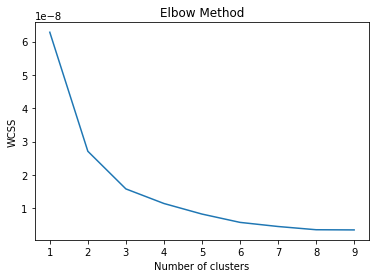

In [26]:
ClusterNum(park, weighted="AreaSize")

In [27]:
park_model, park_center = ClusterModel(6, park, weighted="AreaSize")

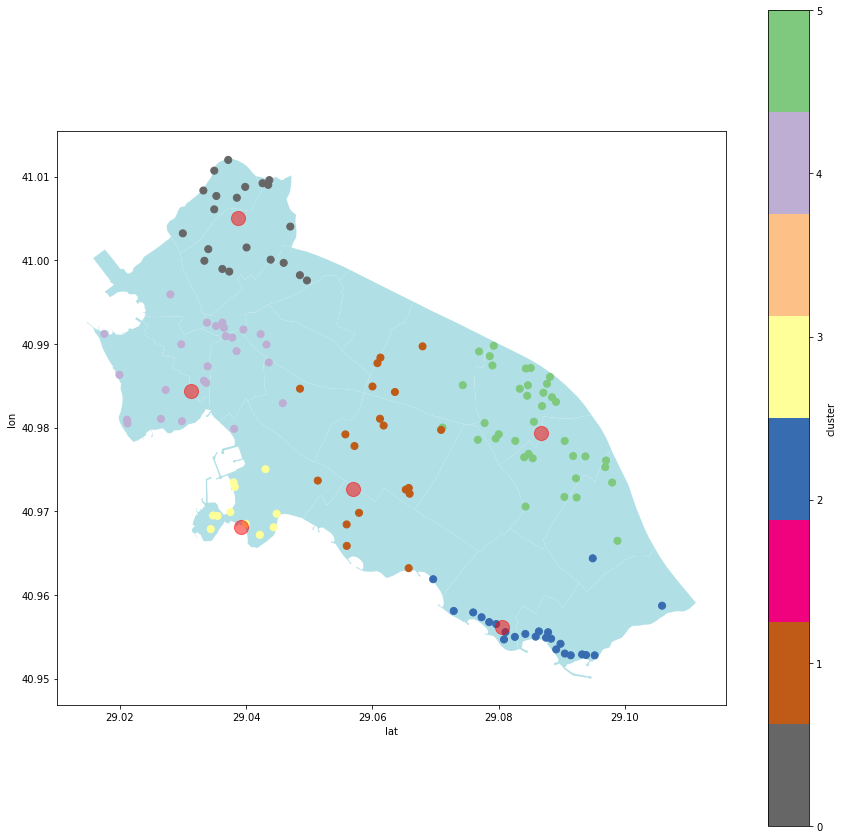

In [28]:
ClusterMap(park_model, park_center)

In [29]:
DrawRealMap(park_center, "green")

#### Kadıköy Shopping Centers Map

In [30]:
sh_mall = gpd.read_file('..\Data\ShoppingMall.geojson')       # for local
#sh_mall = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/ShoppingMall.geojson')               # for Colab
sh_mall["AreaSize"] = sh_mall.area

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2081645640.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh_mall["AreaSize"] = sh_mall.area


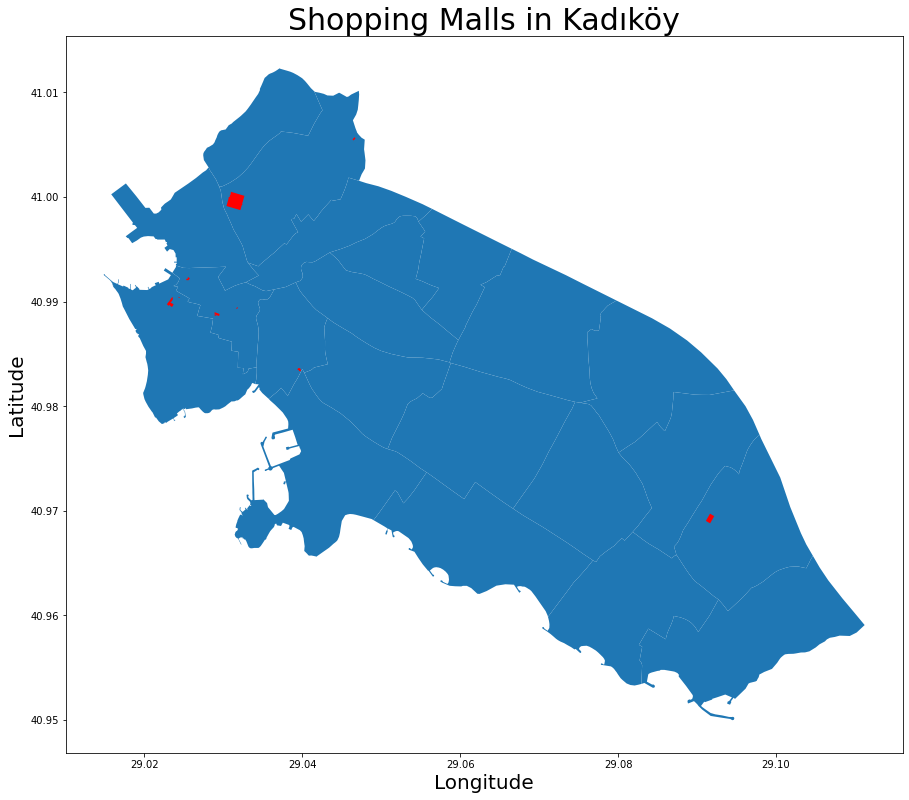

In [31]:
DrawMap(sh_mall, "Shopping Malls in Kadıköy")

In [32]:
sh_mall = CentAndLatLot(sh_mall)

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


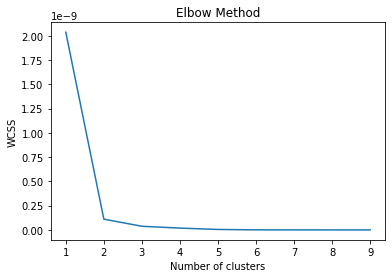

In [33]:
ClusterNum(sh_mall, weighted="AreaSize")

In [34]:
shop_model, shop_center = ClusterModel(2, sh_mall, weighted="AreaSize")

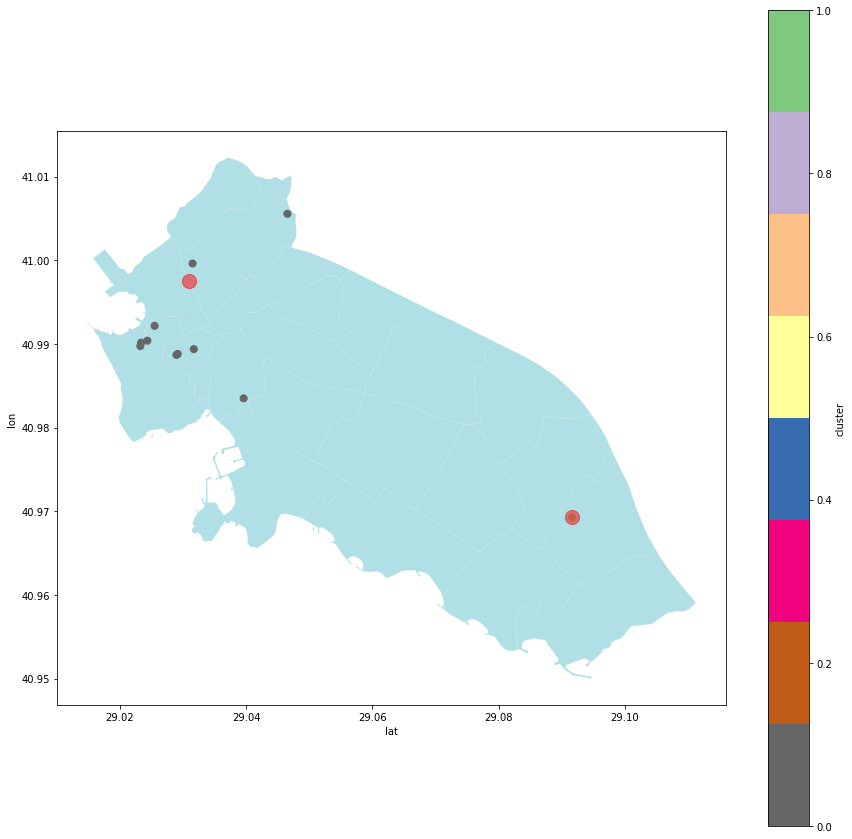

In [35]:
ClusterMap(shop_model, shop_center)

In [36]:
DrawRealMap(shop_center, "gray")

#### Kadıköy Educational Areas Map

In [37]:
uni = gpd.read_file(r'..\Data\University.geojson')        # for local
eduNode = gpd.read_file(r'..\Data\School.geojson')        # for local
#uni = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/University.geojson')                 # for Colab
#eduNode = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/School.geojson')                 # for Colab

eduNode = eduNode.append(uni, ignore_index=True)
eduNode['weight'] = 1

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\1183195414.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eduNode = eduNode.append(uni, ignore_index=True)


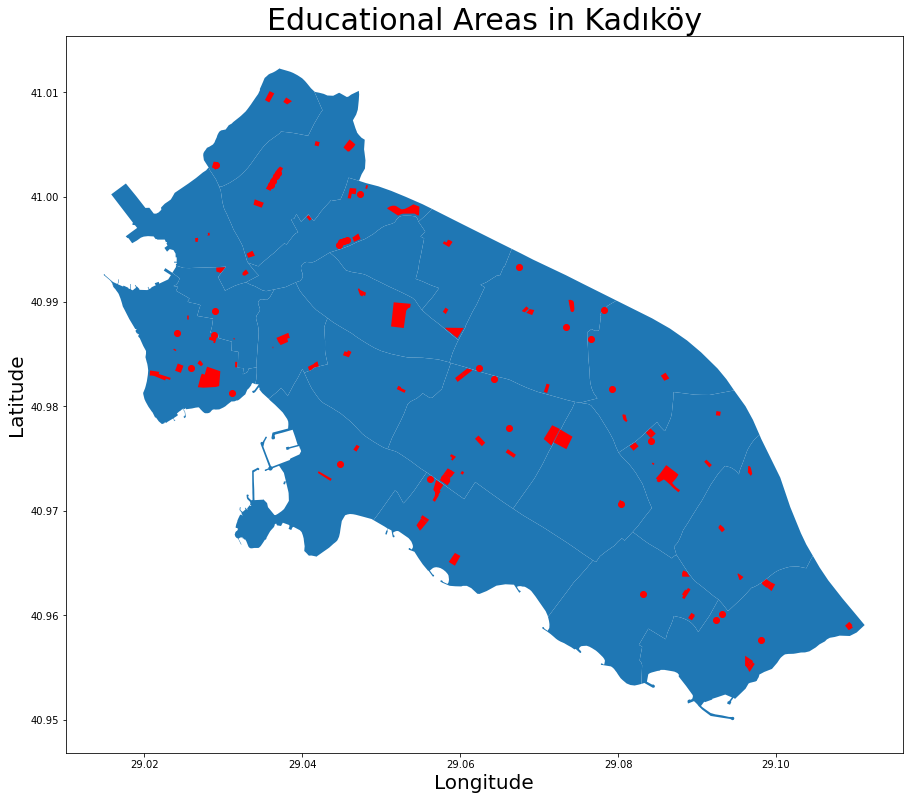

In [38]:
DrawMap(eduNode, "Educational Areas in Kadıköy")

In [39]:
eduNode = CentAndLatLot(eduNode)

C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\2648575528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


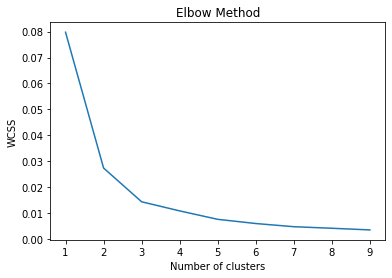

In [40]:
ClusterNum(eduNode)

In [41]:
edu_model, edu_center = ClusterModel(3, eduNode)

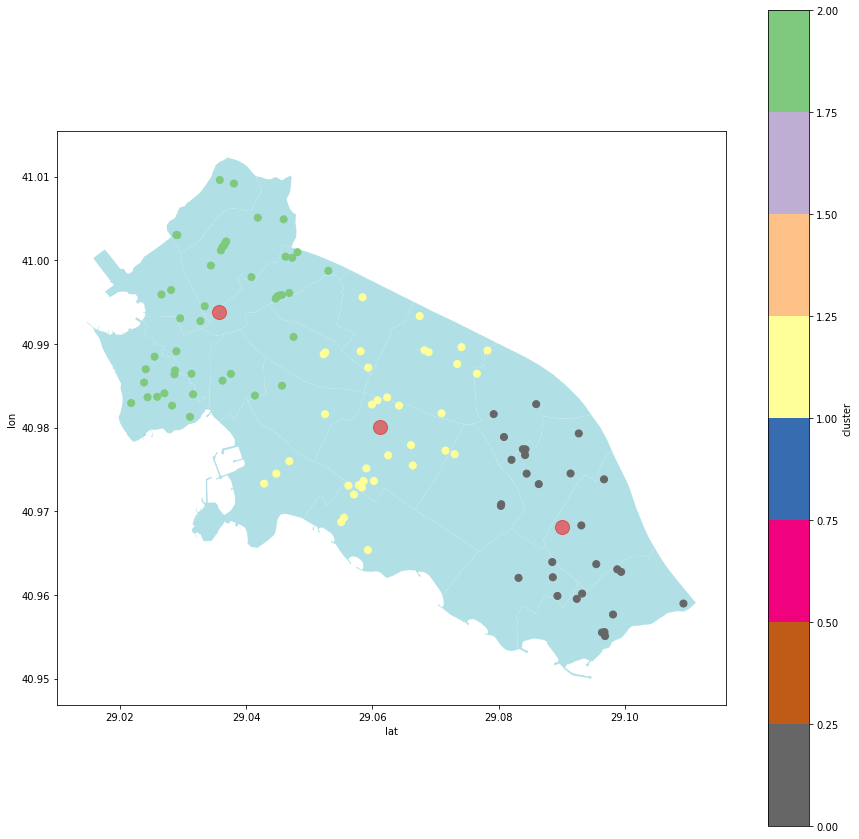

In [42]:
ClusterMap(edu_model, edu_center)

In [43]:
DrawRealMap(edu_center, "blue")

#### Unification of All Centers

In [44]:
arr = np.concatenate((public_center, density_center, park_center, shop_center, edu_center))

In [45]:
# Turning centers into dataframes
df_center = pd.DataFrame(arr, columns=['lat', 'lon'])
df_center['name'] = ['public_center', 'public_center', 'public_center', 
                     'density_center', 'density_center', 'density_center', 
                     'park_center', 'park_center', 'park_center', 'park_center', 
                     'park_center', 'park_center', 'shop_center', 'shop_center', 
                     'edu_center', 'edu_center', 'edu_center']

In [46]:
# Creating the weight column
df_center['weight'] = 1.0
for i in range(len(df_center)):
    if df_center.iloc[i, 2] == "public_center":
        df_center.weight[i] = 0.526529232848935
    elif df_center.iloc[i, 2] == "density_center":
        df_center.weight[i] = 0.127407908077053
    elif df_center.iloc[i, 2] == "park_center":
        df_center.weight[i] = 0.159175397093613
    elif df_center.iloc[i, 2] == "shop_center":
        df_center.weight[i] = 0.0594795539033457
    elif df_center.iloc[i, 2] == "edu_center":
        df_center.weight[i] = 0.127407908077053


C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\3254447053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center.weight[i] = 0.526529232848935
C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\3254447053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center.weight[i] = 0.127407908077053
C:\Users\akdem\AppData\Local\Temp\ipykernel_19212\3254447053.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center.weight[i] 

In [47]:
geometry = [Point(xy) for xy in zip(df_center.lon, df_center.lat)]
df2 = df_center.copy()
#df2 = df2.drop(['lon', 'lat'], axis=1)
gdf2 = GeoDataFrame(df2, crs="EPSG:4326", geometry=geometry)
gdf2

,lat,lon,name,weight,geometry
0,29.036810,40.996919,public_center,0.526529,POINT (40.99692 29.03681)
1,29.056177,40.978388,public_center,0.526529,POINT (40.97839 29.05618)
2,29.087633,40.974600,public_center,0.526529,POINT (40.97460 29.08763)
3,29.055591,40.982105,density_center,0.127408,POINT (40.98211 29.05559)
4,29.087112,40.968717,density_center,0.127408,POINT (40.96872 29.08711)
5,29.034058,40.995365,density_center,0.127408,POINT (40.99536 29.03406)
6,29.038719,41.005097,park_center,0.159175,POINT (41.00510 29.03872)
7,29.056970,40.972618,park_center,0.159175,POINT (40.97262 29.05697)
8,29.080614,40.956207,park_center,0.159175,POINT (40.95621 29.08061)
9,29.039249,40.968101,park_center,0.159175,POINT (40.96810 29.03925)


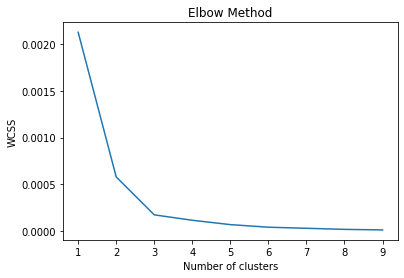

In [48]:
ClusterNum(df_center)

In [49]:
center_model, center_center = ClusterModel(3, df_center)

#### Showing Determined İsbike Points on the Map

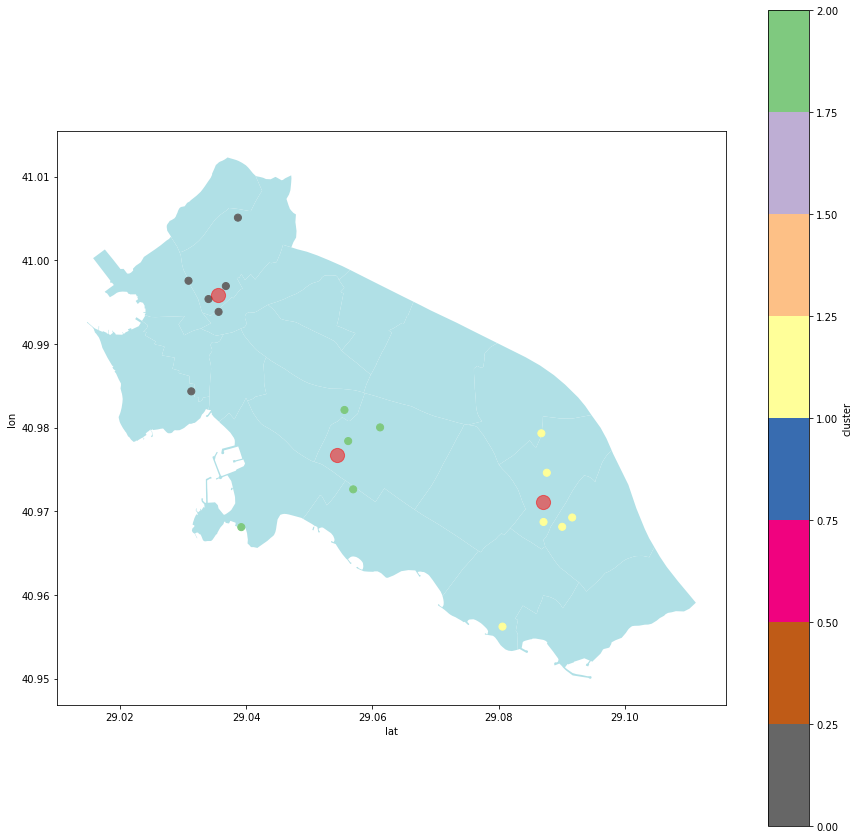

In [50]:
ClusterMap(center_model, center_center)

In [51]:
DrawRealMap(center_center, 'pink')